In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# define column sets
feature_columns = {
    "base_cols" : ['volume_eth', 'price_p5_eth', 'price_max_eth', 'price_min_eth',
                'rarity_rank'],
    "base_traits" : ['Background_count', 'Mouth_count', 'Eyes_count', 'Fur_count'],
    "extra_traits" : ['Hat_count', 'Clothes_count', 'Earring_count'],
    "last_trade" : ['last_trade_timediff', 'last_trade_price'],
}

outcome_columns = {
    'price_eth' : 'trade_price',
    'price_usd' : 'amount_usd',
    'lnprice_eth' : 'ln_trade_price', #TODO
    'lnprice_eth' : 'ln_amount_usd' #TODO
}

In [3]:
X_cols_1 = feature_columns['base_cols'] + feature_columns['base_traits'] + feature_columns['last_trade']
y_col_1 = "trade_price"

In [4]:
data = pd.read_csv("data/bayc_cleaned.csv")

data = data.dropna(subset=X_cols_1+[y_col_1])
X = data[X_cols_1]
y = data[y_col_1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer for prediction

In [6]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [7]:
# model config/ training
import wandb
from wandb.keras import WandbCallback
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mingxuan-he. Use `wandb login --relogin` to force relogin


True

In [8]:
wandb.init(project="bayc", entity="mingxuan-he")
config = wandb.config
config.learning_rate = 0.01
config.epochs = 10
config.batch_size = 32

In [9]:
model.fit(
    X_train, 
    y_train, 
    epochs=config.epochs,
    validation_data=(X_test, y_test), 
    batch_size=config.batch_size, 
    callbacks=[WandbCallback()])
wandb.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
856/860 [============================>.] - ETA: 0s - loss: 856.0603WARNING:tensorflow:From c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1813: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best)... Done. 0.0s


860/860 [==============================] - 1s 1ms/step - loss: 853.3048 - val_loss: 429.0990
Epoch 2/10
737/860 [========================>.....] - ETA: 0s - loss: 402.4237INFO:tensorflow:Assets written to: c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best)... Done. 0.0s


860/860 [==============================] - 1s 905us/step - loss: 417.9860 - val_loss: 391.8601
Epoch 3/10
759/860 [=========================>....] - ETA: 0s - loss: 395.4404INFO:tensorflow:Assets written to: c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best)... Done. 0.0s


860/860 [==============================] - 1s 901us/step - loss: 395.1592 - val_loss: 371.1491
Epoch 4/10
850/860 [============================>.] - ETA: 0s - loss: 376.9225INFO:tensorflow:Assets written to: c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best)... Done. 0.0s


860/860 [==============================] - 1s 944us/step - loss: 379.0103 - val_loss: 363.3239
Epoch 5/10
743/860 [========================>.....] - ETA: 0s - loss: 381.3979INFO:tensorflow:Assets written to: c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best)... Done. 0.0s


860/860 [==============================] - 1s 937us/step - loss: 373.7658 - val_loss: 351.5523
Epoch 6/10
813/860 [===========================>..] - ETA: 0s - loss: 360.7188INFO:tensorflow:Assets written to: c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best)... Done. 0.0s


860/860 [==============================] - 1s 1ms/step - loss: 359.3988 - val_loss: 342.4567
Epoch 7/10
844/860 [============================>.] - ETA: 0s - loss: 337.4383INFO:tensorflow:Assets written to: c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\sheld\OneDrive\BUSN 41913 Bayes, AI, and Deep Learning\NFT_pred\wandb\run-20231129_230947-f8t6zdiq\files\model-best)... Done. 0.0s


860/860 [==============================] - 1s 927us/step - loss: 351.4937 - val_loss: 325.0730
Epoch 8/10
860/860 [==============================] - 0s 499us/step - loss: 345.7977 - val_loss: 331.4471
Epoch 9/10
860/860 [==============================] - 0s 521us/step - loss: 339.9682 - val_loss: 360.3684
Epoch 10/10
860/860 [==============================] - 0s 576us/step - loss: 335.0451 - val_loss: 332.8818


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▂▁▁▁▁▁
val_loss,█▅▄▄▃▂▁▁▃▂
best_epoch,6
best_val_loss,325.073
epoch,9
loss,335.04507
val_loss,332.88177


In [10]:
predictions = model.predict(X_test)

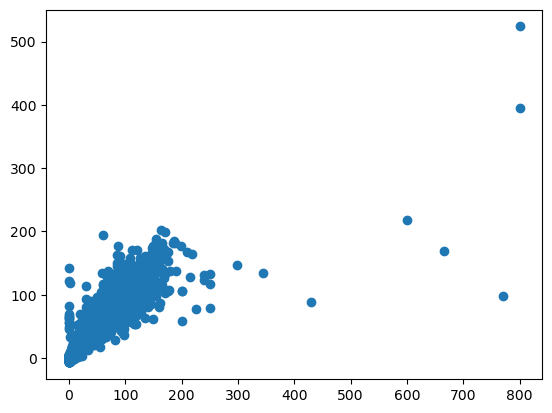

In [11]:
import matplotlib.pyplot as plt
plt.scatter(y_test, predictions)
plt.show()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


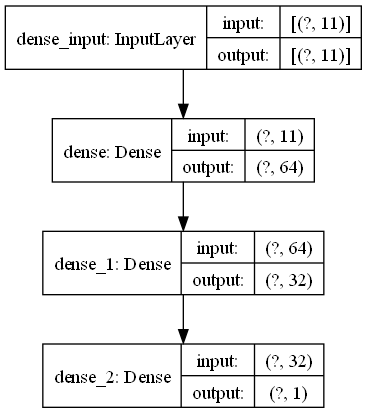

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [14]:
from keras_visualizer import visualizer
visualizer(model, file_name="figures/nn", file_format='png', view=True)